In [2]:
import pickle
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import scipy.stats as ss  
import pingouin as pg
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import randint, uniform
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import ridge_regression, Lasso, Ridge
import random
import locale
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV



# Inter
from statsmodels.formula.api import ols
import shap
import lime 
import lime.lime_tabular

# SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf



c:\Users\sarah\miniconda3\envs\raku\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Chargement des modèles préalablement entraînés
with open('C:/Users/sarah/OneDrive/Documents/GitHub/DS_RakutenVF/00 - Annexes/models/model_lr.pkl', 'rb') as file:
    model_lr = pickle.load(file)
with open('C:/Users/sarah/OneDrive/Documents/GitHub/DS_RakutenVF/00 - Annexes/models/model_rf.pkl', 'rb') as file:
    model_rf = pickle.load(file)
with open('C:/Users/sarah/OneDrive/Documents/GitHub/DS_RakutenVF/00 - Annexes/models/best_xgb_model.pkl', 'rb') as file:
    best_xgb_model = pickle.load(file)
with open('C:/Users/sarah/OneDrive/Documents/GitHub/DS_RakutenVF/00 - Annexes/models/model_ridge.pkl', 'rb') as file:
    model_ridge = pickle.load(file)
with open('C:/Users/sarah/OneDrive/Documents/GitHub/DS_RakutenVF/00 - Annexes/models/model_lasso.pkl', 'rb') as file:
    model_lasso = pickle.load(file)
with open('C:/Users/sarah/OneDrive/Documents/GitHub/DS_RakutenVF/00 - Annexes/models/model_dt.pkl', 'rb') as file:
    model_dt = pickle.load(file)
with open('C:/Users/sarah/OneDrive/Documents/GitHub/DS_RakutenVF/00 - Annexes/models/sarimax_model.pkl', 'rb') as file:
    model_lr = pickle.load(file)

c:\Users\sarah\miniconda3\envs\raku\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\sarah\miniconda3\envs\raku\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\sarah\miniconda3\envs\raku\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.0 when using vers

In [5]:
# Importation des jeux de données
df_validation = pd.read_csv("C:/Users/sarah/OneDrive/Documents/GitHub/DS_RakutenVF/00 - Annexes/data_prepro/donnees_validation.csv")

# Séparation des colonnes SKU, Date et DateLancement pour les réutiliser lors des prédictions
sku_validation = df_validation[['SKU', 'Date', 'DateLancement']]

# Suppression des colonnes SKU, Date et DateLancement des ensembles de validation
df_validation.drop(columns=['SKU', 'Date', 'DateLancement'], inplace=True)

# Colonnes à exclure pour correspondre à celles utilisées lors de l'entraînement
columns_to_exclude = [
    'Elasticite', 'ChocDemande', 'FacteurRarete', 'Categorie_Livres',
    'Categorie_Vetements', 'elasticite_cat_Inelastique', 'elasticite_cat_Neutre', 'year',
    'dayofweek', 'launch_dayofweek', 'launch_is_weekend', 'TempsDepuisLancement', 
    'is_weekend', 'TauxInflation', 'ChocDemandeCumulatif',
]

# Filtrer les données de validation en excluant les colonnes définies
df_validation_filtered = df_validation.drop(columns=columns_to_exclude)

In [6]:
# Sélectionner une observation aléatoire à partir des données de validation
random_index = random.randint(0, len(sku_validation) - 1)
random_observation = sku_validation.iloc[random_index]
random_sku = random_observation['SKU']
random_date = random_observation['Date']

# Ajouter la colonne Moving_Avg dans df_validation pour une moyenne mobile
window_size = 3
df_validation_filtered['Moving_Avg'] = df_validation['Prix'].rolling(window=window_size).mean()

# Filtrer le DataFrame `sku_validation` pour obtenir l'observation correspondante
df_random_index = sku_validation[(sku_validation['SKU'] == random_sku) & (sku_validation['Date'] == random_date)].index

# Vérifier que l'observation est unique
if len(df_random_index) != 1:
    raise ValueError("L'observation sélectionnée n'est pas unique.")

# Extraire l'indice de l'observation
index_random = df_random_index[0]

# Stocker le vrai prix à partir de l'indice dans df_validation_filtered
y_actual_log = df_validation.loc[index_random, 'Prix']
y_actual = np.exp(y_actual_log)  # Inverser la transformation logarithmique pour obtenir le prix réel

# Récupérer la ligne correspondante pour les prédictions
df_random_reg = df_validation_filtered.loc[[index_random]].drop(columns=['Prix'])  # Suppression de la cible 'Prix'




# Définir les colonnes de référence à partir de l'entraînement initial
# Pour statsmodels, nous utilisons les colonnes du DataFrame d'origine
training_columns = df_validation_filtered.columns.tolist()

# Pour scikit-learn, utiliser 'feature_names_in_' si disponible
try:
    sklearn_training_columns = model_rf.feature_names_in_
except AttributeError:
    sklearn_training_columns = training_columns
    

# Ajouter les colonnes manquantes avec des zéros pour assurer la compatibilité avec le modèle
missing_cols_statsmodels = set(training_columns) - set(df_random_reg.columns)
for col in missing_cols_statsmodels:
    df_random_reg[col] = 0

# Assurer que l'ordre des colonnes est le même que lors de l'entraînement pour statsmodels
df_random_reg = df_random_reg[training_columns]

# Ajouter les colonnes manquantes pour les modèles scikit-learn
missing_cols_sklearn = set(sklearn_training_columns) - set(df_random_reg.columns)
for col in missing_cols_sklearn:
    df_random_reg[col] = 0

# Assurer que l'ordre des colonnes est le même que lors de l'entraînement pour scikit-learn
df_random_reg = df_random_reg[sklearn_training_columns]

# Prédictions avec les différents modèles
y_pred_lr_log = model_lr.predict(df_random_reg).tolist()[0]
y_pred_rf_log = model_rf.predict(df_random_reg).tolist()[0]
y_pred_xgb_log = best_xgb_model.predict(df_random_reg).tolist()[0]
y_pred_ridge_log = model_ridge.predict(df_random_reg).tolist()[0]
y_pred_lasso_log = model_lasso.predict(df_random_reg).tolist()[0]
y_pred_dt_log = model_dt.predict(df_random_reg).tolist()[0]

# Récupérer la valeur de Moving_Avg pour l'observation
y_pred_moving_avg_log = df_validation_filtered.loc[index_random, 'Moving_Avg']
y_pred_moving_avg = np.exp(y_pred_moving_avg_log)  # Inverser la transformation logarithmique

# Inverser la transformation logarithmique pour obtenir les valeurs originales des prédictions
y_pred_lr = np.exp(y_pred_lr_log)
y_pred_rf = np.exp(y_pred_rf_log)
y_pred_xgb = np.exp(y_pred_xgb_log)
y_pred_ridge = np.exp(y_pred_ridge_log)
y_pred_lasso = np.exp(y_pred_lasso_log)
y_pred_dt = np.exp(y_pred_dt_log)

# Comparer les prédictions avec le vrai prix
print(f"SKU sélectionné: {random_sku}")
print(f"Date sélectionnée: {random_date}")
print(f"Prix réel: {y_actual}")
print(f"Prédiction Régression Linéaire (après transformation): {y_pred_lr}")
print(f"Prédiction Random Forest (après transformation): {y_pred_rf}")
print(f"Prédiction XGBoost (après transformation): {y_pred_xgb}")
print(f"Prédiction Moyenne Mobile (après transformation): {y_pred_moving_avg}")
print(f"Prédiction Ridge (après transformation): {y_pred_ridge}")
print(f"Prédiction Lasso (après transformation): {y_pred_lasso}")
print(f"Prédiction Decision Tree (après transformation): {y_pred_dt}")


SKU sélectionné: Electronique_SKU_1301
Date sélectionnée: 2022-03-27 21:29:40.294768
Prix réel: 588.8857207825795
Prédiction Régression Linéaire (après transformation): 446.7922056720913
Prédiction Random Forest (après transformation): 584.5763409604523
Prédiction XGBoost (après transformation): 595.0197673200225
Prédiction Moyenne Mobile (après transformation): 374.8018665532026
Prédiction Ridge (après transformation): 446.6274612943256
Prédiction Lasso (après transformation): 537.0197128116193
Prédiction Decision Tree (après transformation): 593.2018292569106


In [7]:
# List of SKU prefixes for each category
category_prefixes = ['Electronique', 'Vetements', 'Livres']
category_random_skus = {}

# Select a random SKU based on its prefix using the SKU information from sku_validation
for prefix in category_prefixes:
    df_category = sku_validation[sku_validation['SKU'].str.startswith(prefix)]
    if not df_category.empty:
        random_sku = df_category['SKU'].sample(n=1).values[0]
        category_random_skus[prefix] = random_sku


In [8]:
predictions = {}

# Loop through each category and SKU to generate predictions
for prefix, random_sku in category_random_skus.items():
    # Filter data for the randomly selected SKU using sku_validation
    df_category_sku = sku_validation[sku_validation['SKU'] == random_sku].copy()
    df_category_sku['Moving_Avg'] = df_validation['Prix'].rolling(window=3).mean()

    # Get the corresponding rows in the validation data for the SKU
    df_random_reg = df_validation_filtered.loc[df_category_sku.index].copy()

    # Add missing columns to match the training features for statsmodels
    missing_cols_statsmodels = set(training_columns) - set(df_random_reg.columns)
    for col in missing_cols_statsmodels:
        df_random_reg[col] = 0

    # Ensure the columns are in the same order as during training for statsmodels
    df_random_reg = df_random_reg[training_columns]

    # Add missing columns to match the training features for scikit-learn
    missing_cols_sklearn = set(sklearn_training_columns) - set(df_random_reg.columns)
    for col in missing_cols_sklearn:
        df_random_reg[col] = 0

    # Ensure the columns are in the same order as during training for scikit-learn
    df_random_reg = df_random_reg[sklearn_training_columns]

    # Make predictions with the trained models
# Revert the log transformation on the actual price
    y_actual_log = df_validation.loc[df_category_sku.index, 'Prix'].values
    y_pred_lr_log = model_lr.predict(df_random_reg)
    y_pred_rf_log = model_rf.predict(df_random_reg)
    y_pred_xgb_log = best_xgb_model.predict(df_random_reg)
    y_pred_ridge_log = model_ridge.predict(df_random_reg)
    y_pred_lasso_log = model_lasso.predict(df_random_reg)
    y_pred_dt_log = model_dt.predict(df_random_reg)
    y_pred_moving_avg_log = df_category_sku['Moving_Avg'].values

    # Apply exponential transformation to revert from logarithmic scale
    y_pred_lr = np.exp(y_pred_lr_log)
    y_actual = np.exp(y_actual_log)  # Inverser la transformation logarithmique pour obtenir le prix réel
    y_pred_rf = np.exp(y_pred_rf_log)
    y_pred_xgb = np.exp(y_pred_xgb_log)
    y_pred_ridge = np.exp(y_pred_ridge_log)
    y_pred_lasso = np.exp(y_pred_lasso_log)
    y_pred_dt = np.exp(y_pred_dt_log)
    y_pred_moving_avg = np.exp(y_pred_moving_avg_log)

    predictions[prefix] = {
        'y_actual': y_actual,
        'y_pred_lr': y_pred_lr,
        'y_pred_rf': y_pred_rf,
        'y_pred_xgb': y_pred_xgb,
        'y_pred_ridge': y_pred_ridge,
        'y_pred_lasso': y_pred_lasso,
        'y_pred_dt': y_pred_dt,
        'y_pred_moving_avg': y_pred_moving_avg,
        'dates': df_category_sku['Date'].values
    }


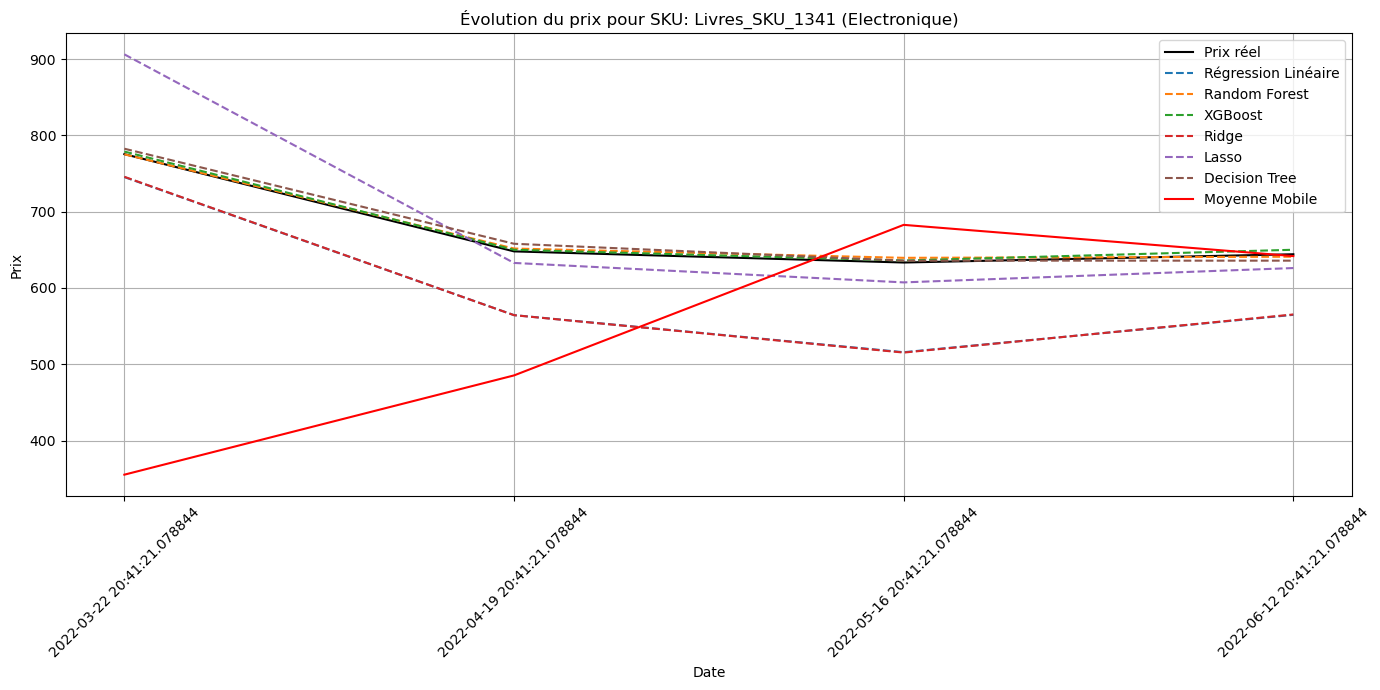

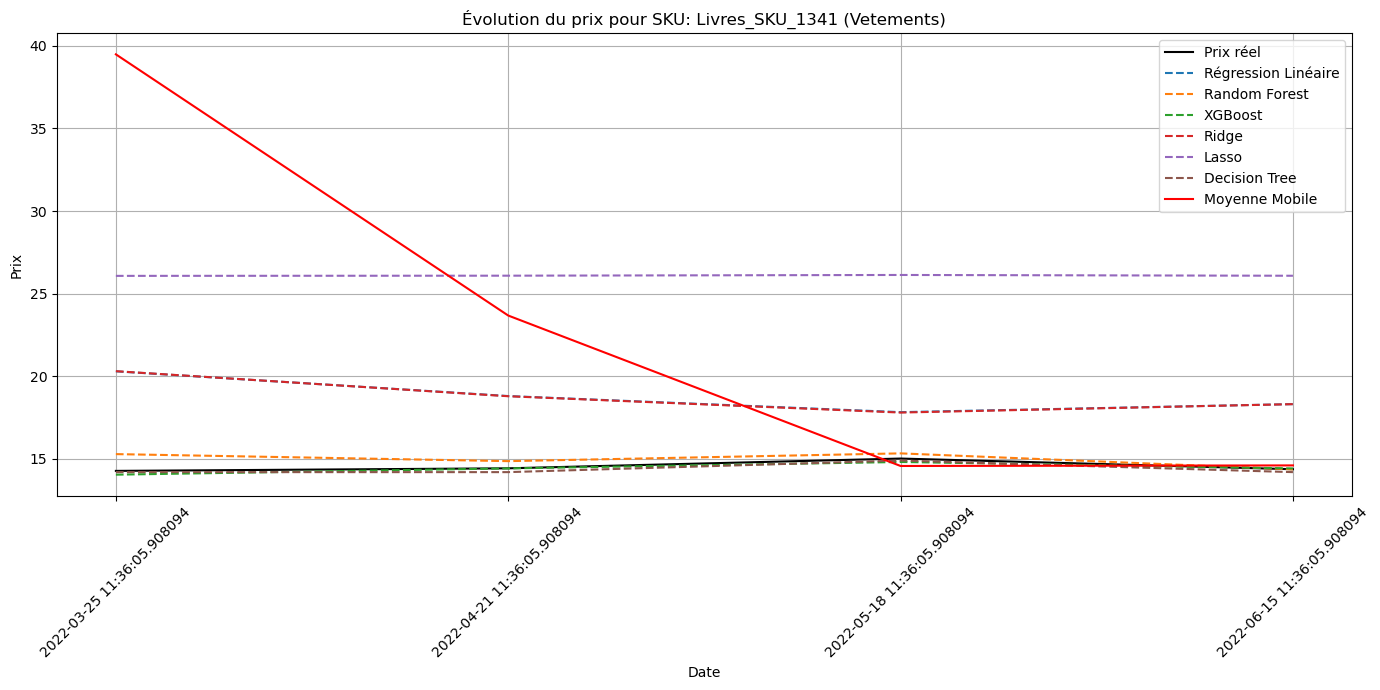

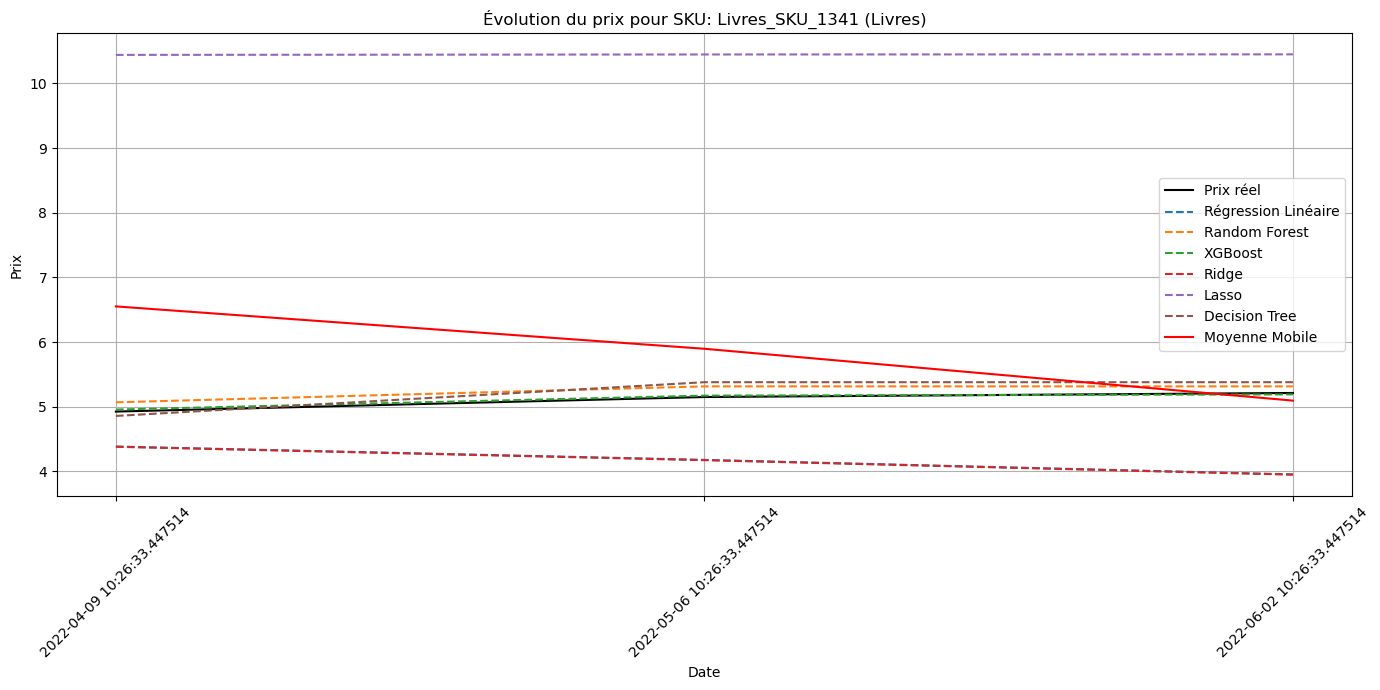

In [9]:
# Generate the graphs for each category prefix
for prefix, preds in predictions.items():
    plt.figure(figsize=(14, 7))
    plt.plot(preds['dates'], preds['y_actual'], label='Prix réel', color='black')
    plt.plot(preds['dates'], preds['y_pred_lr'], label='Régression Linéaire', linestyle='--')
    plt.plot(preds['dates'], preds['y_pred_rf'], label='Random Forest', linestyle='--')
    plt.plot(preds['dates'], preds['y_pred_xgb'], label='XGBoost', linestyle='--')
    plt.plot(preds['dates'], preds['y_pred_ridge'], label='Ridge', linestyle='--')
    plt.plot(preds['dates'], preds['y_pred_lasso'], label='Lasso', linestyle='--')
    plt.plot(preds['dates'], preds['y_pred_dt'], label='Decision Tree', linestyle='--')
    plt.plot(preds['dates'], preds['y_pred_moving_avg'], label='Moyenne Mobile', color='red')

    plt.xlabel('Date')
    plt.ylabel('Prix')
    plt.title(f'Évolution du prix pour SKU: {random_sku} ({prefix})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

